In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/Shareddrives/DL4CV/

In [2]:
# !pip install gdown

In [3]:
# !gdown https://drive.google.com/uc?id=1WEWBSy39Jhy51vUEK9f2CyDli-5rkXtX^C

## Import libraries

In [4]:
# !pip install timm
# !pip install natten
# !pip install einops 

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import timm
from tqdm.auto import tqdm
from torchvision import datasets, transforms
import random
from sklearn.metrics import classification_report
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

## Visualize Images

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# Path to the data
data_dir = Path("data/")

unique_labels =  ['early_blight', 'mosaic_virus', 'yellow_leaf_curl_virus', 'healthy', 'bacterial_spot', 'septoria_leaf_spot', 'late_blight', 'target_spot', 'two-spotted_spider_mite', 'powdery_mildew', 'leaf_mold']


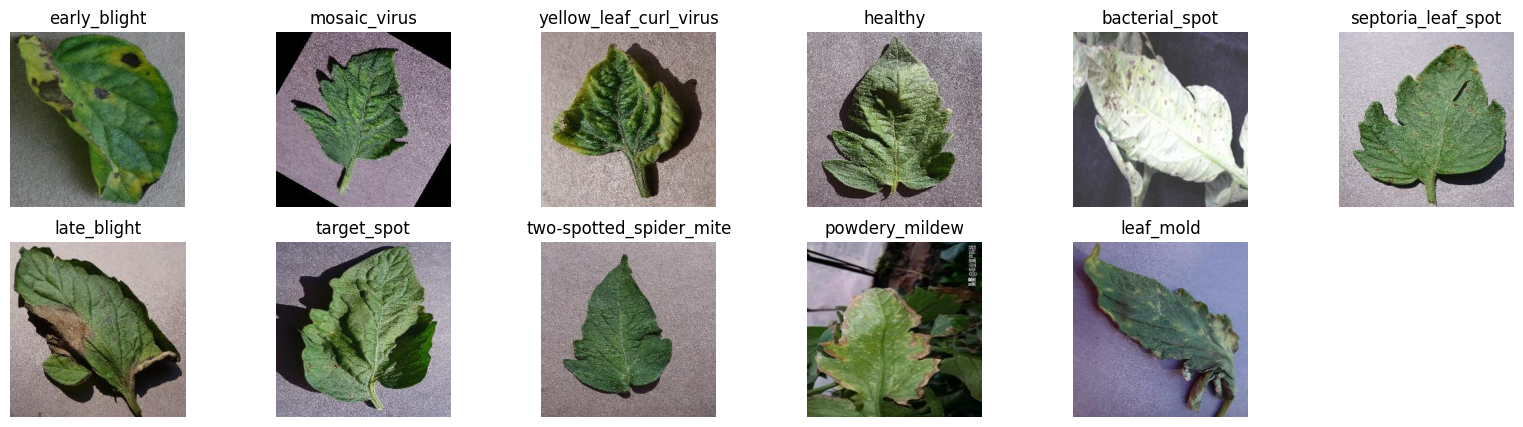

In [8]:
def load_unique():
    images_for_plot = []
    labels_for_plot = []
    for folder in os.listdir(data_dir):
        for file in os.listdir(os.path.join(data_dir,folder)):
            filepath = os.path.join(data_dir, folder, file)
            image = cv2.imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images_for_plot.append(image)
            labels_for_plot.append(folder)
            break
    return images_for_plot, labels_for_plot

images_for_plot, labels_for_plot = load_unique()
print("unique_labels = ", labels_for_plot)

fig = plt.figure(figsize = (20,5))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 2
col = 6
for i in range(1,(row*col)):
    plot_images(fig, images_for_plot[image_index], labels_for_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

Random image path: data/late_blight/a07f7609-5248-4cbc-a277-5d962e1d0dd1___GHLB2 Leaf 148.4.JPG
Image class: late_blight
Image height: 256
Image width: 256


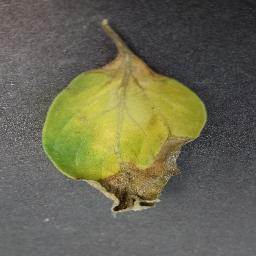

In [9]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")S
image_path_list = list(data_dir.glob("*/*"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

## Processing & Augment Data

In [10]:
# Declare transform steps for train, valid and test sets
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

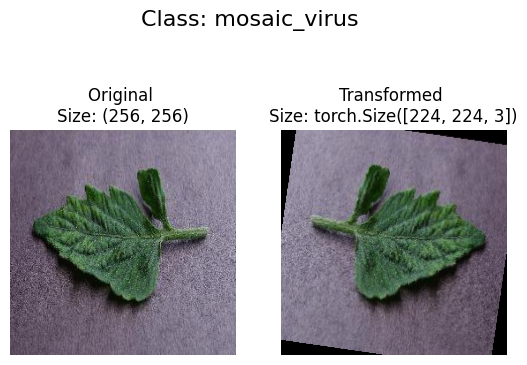

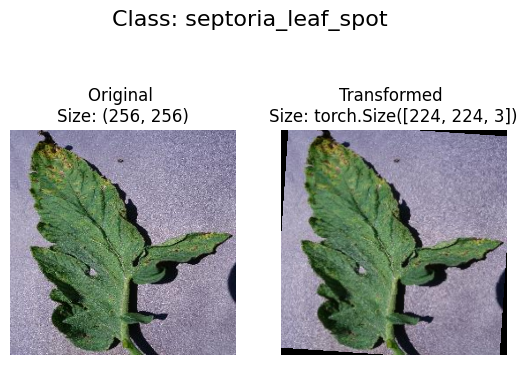

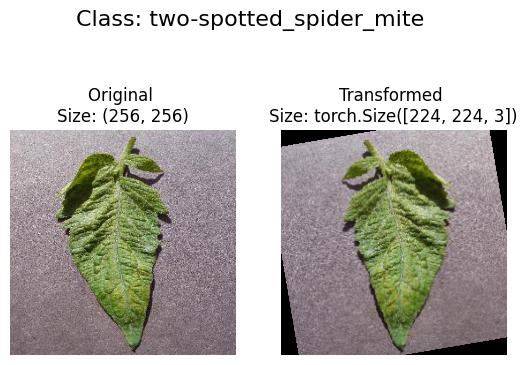

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=1):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=train_transforms,
                        n=3)

In [12]:
# Create dataset
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
dataset = datasets.ImageFolder(root=data_dir)

print(f"Dataset:\n{dataset}")

Dataset:
Dataset ImageFolder
    Number of datapoints: 32535
    Root location: data


In [13]:
# Can also get class names as a dict
class_dict = dataset.class_to_idx
class_dict

{'bacterial_spot': 0,
 'early_blight': 1,
 'healthy': 2,
 'late_blight': 3,
 'leaf_mold': 4,
 'mosaic_virus': 5,
 'powdery_mildew': 6,
 'septoria_leaf_spot': 7,
 'target_spot': 8,
 'two-spotted_spider_mite': 9,
 'yellow_leaf_curl_virus': 10}

In [14]:
# Count total number of images
total_images = len(dataset)
total_images

32535

In [15]:
random.seed(42)
# Count number of images in each set
train_size = int(0.7 * total_images)
valid_size = int(0.2 * total_images)
test_size = total_images - train_size - valid_size

# Use random to shuffle the data
indices = list(range(total_images))
random.shuffle(indices)

# Divide the data into train, valid, and test sets
train_indices = indices[:train_size]
valid_indices = indices[train_size:train_size+valid_size]
test_indices = indices[train_size+valid_size:]

# Create datasets for each set
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Apply transform steps to each dataset
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = valid_transforms
test_dataset.dataset.transform = test_transforms

# Create dataloaders for each set
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
img_custom, label_custom = next(iter(train_dataloader))
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## Model

In [17]:
# from models.convnext.convnext import *
# convnext_model = convnext_tiny(pretrained=True).to(device)
# from models.swin.swin_transformer import *
# convnext_model = swin_tiny(pretrained=True, num_classes=len(class_dict)).to(device)
# from models.nasnet.nasnet import *
# convnext_model = nasnetamobile(num_classes=len(class_dict)).to(device)
from models.nat.nat import *
convnext_model = nat_mini(num_classes=len(class_dict), pretrained=True).to(device)
# from models.flatten.flatten_transformer import *
# convnext_model = flatten_swin_tiny(num_classes=len(class_dict), pretrained=True).to(device)

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [19]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    val_loss, val_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            val_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)
    return val_loss, val_acc

In [20]:
# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          val_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          model_name:str = None):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    val_acc_best = 0
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        val_loss, val_acc = val_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)

        # Save best model
        if val_acc > val_acc_best:
            print(f'Save best model on epoch {epoch}')
            torch.save(model.state_dict(), model_name)
            val_acc_best = val_acc

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## Training

In [21]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Set number of epochs
NUM_EPOCHS = 5

model_name = 'convnext.pth'
checkpoints = os.path.join('checkpoints',model_name)
convnext_model = convnext_model.to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=convnext_model.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=convnext_model,
                        train_dataloader=train_dataloader,
                        val_dataloader=valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        model_name = checkpoints)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    val_loss = results['val_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    val_accuracy = results['val_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

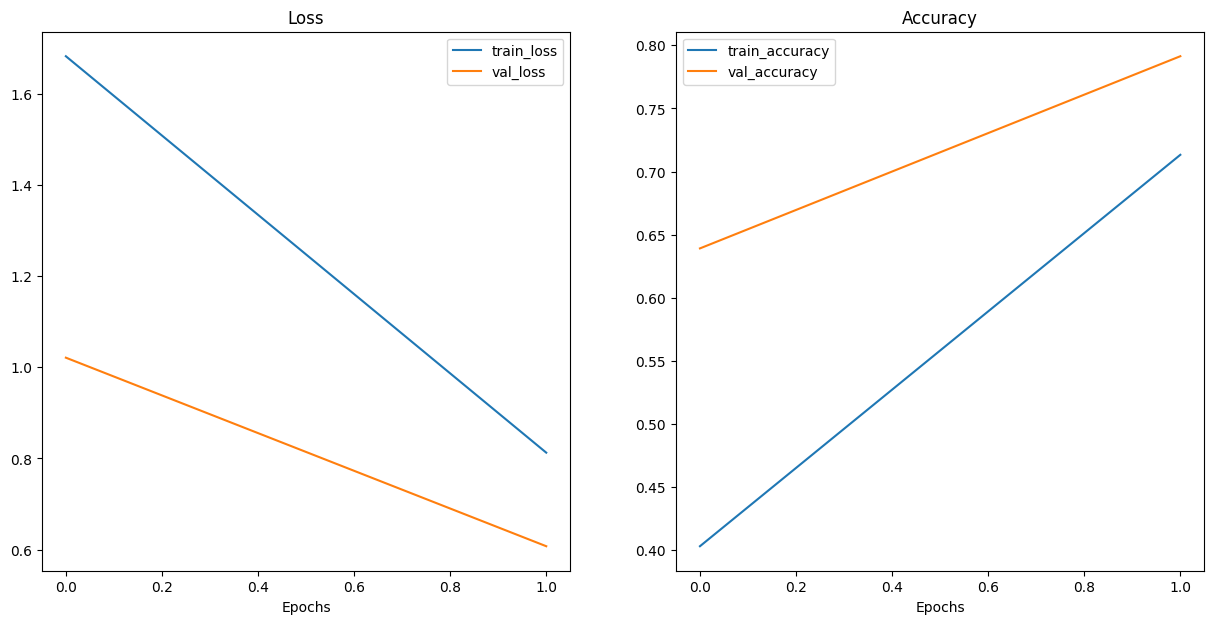

In [ ]:
plot_loss_curves(model_results)

## Testing model

In [ ]:
from sklearn.metrics import classification_report

def evaluate(model, test_dataloader, device, model_path):
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    # Set model to evaluation mode
    model.eval()

    # Initialize lists for true and predicted labels
    y_true = []
    y_pred = []

    # Iterate over test data and predict labels
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    return y_true, y_pred

In [ ]:
labels, predicts = evaluate(convnext_model, test_dataloader, device, checkpoints)
# Compute classification report
report = classification_report(labels, predicts)
print(report)

  0%|          | 0/102 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.71      0.84      0.77       351
           1       0.82      0.73      0.78       293
           2       0.81      0.92      0.86       392
           3       0.69      0.66      0.68       397
           4       0.87      0.77      0.82       355
           5       0.97      0.94      0.95       278
           6       0.62      0.65      0.64       141
           7       0.77      0.69      0.73       372
           8       0.83      0.72      0.77       217
           9       0.75      0.92      0.83       211
          10       0.95      0.91      0.93       247

    accuracy                           0.80      3254
   macro avg       0.80      0.80      0.79      3254
weighted avg       0.80      0.80      0.80      3254



Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

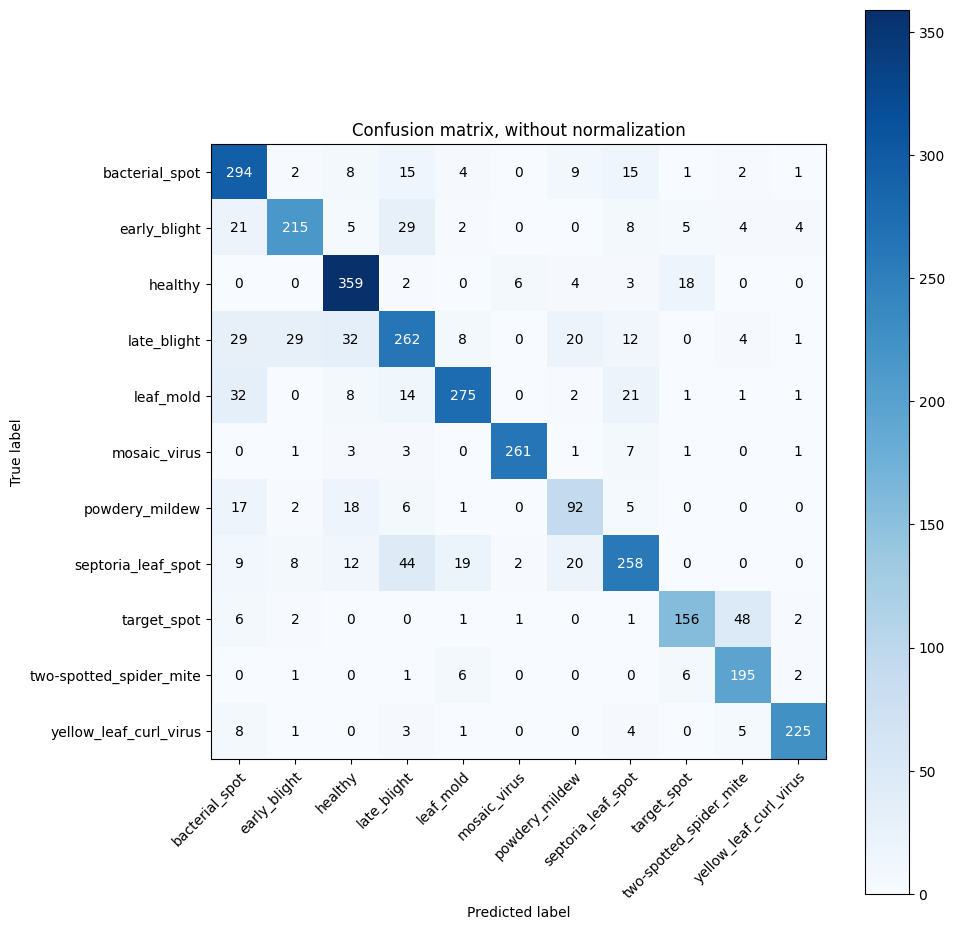

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(labels, predicts)
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(labels, predicts, classes = class_dict.keys())
plt.show()

In [ ]:
def predict_random_image(model, test_dataloader, device, model_path):
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    # Set the seed for reproducibility
    random.seed(42)

    # Get a batch from test_dataloader
    images, labels = next(iter(test_dataloader))

    # Get a random image from the batch
    random_index = random.randint(0, len(images) - 1)
    image = images[random_index]
    label = labels[random_index]

    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image.to(device))
        probabilities = F.softmax(output, dim=1)
        _, predicted = torch.max(output.data, 1)
        probability = probabilities[0][predicted].item()

    plt.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
    plt.title(f"Actual label: {label} | Predicted label: {predicted.item()}, Probability: {probability:.2f}")
    plt.axis("off")
    plt.show()


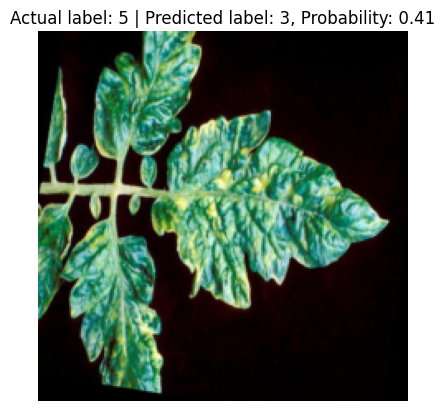

In [ ]:
predict_random_image(convnext_model, test_dataloader, device, checkpoints)